### import the standard foo:

In [1]:
import os,sys
sys.path.append('../..')
sys.path.append('../../../gempy/')
import sandbox.sandbox as sb

import gempy as gp
#import gempy_sandbox as gpsb
import numpy as np
from PIL import Image, ImageDraw
import pickle

../../sandbox/sandbox.py:34: RuntimeWarning: Two kernels cannot access the kinect at the same time. This will lead to a sudden death of the kernel. Be sure no other kernel is running before initialize a kinect object.
  'Be sure no other kernel is running before initialize a kinect object.', RuntimeWarning)


### import the libraries needed for the grid lookup: 

In [2]:
from skimage.transform import resize
import scipy
import scipy.interpolate

In [3]:
geo_model = gp.load_model_pickle(
    r'../../../gempy/notebooks/data/gempy_models/Tutorial_ch1-8_Onlap_relations.pickle')

/home/miguel/anaconda3/lib/python3.6/site-packages/skcuda/cublas.py:283: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


In [4]:
gp.set_interpolation_data(geo_model, theano_optimizer='fast_run')

Compiling theano function...
Compilation Done!


In [5]:
plot_2d = gp.plot.PlotData2D(geo_model)

### Setup the sandbox as usual: 

In [6]:
kinect = sb.Kinect(dummy=True)
projector = sb.Projector(resolution = (1920,1080), work_directory='./temp',
                        refresh=100, input_rescale=False)

calibration_filename = "sandbox_egu19.dat" 
calibration = sb.Calibration(projector)
calibration.load(calibration_file=calibration_filename)
projector.set_calibration(calibration)

dummy mode. get_frame() will return a synthetic depth frame, other functions may not work
calibration data file not found. Using default values


In [7]:
projector.start_stream()   

In [8]:

plot_im = sb.Plot(
    calibration=calibration,
    cmap=plot_2d._cmap,
    norm=plot_2d._norm
    )

In [9]:
#geo_model = gp.read_pickle(r'./../../models/fault1.pickle')

scale=sb.Scale(extent=[   0, 2000,    0, 2000,    0, 2000], calibration=calibration) #initialize scale object to handle the scaling of the model in the andbox
scale.calculate_scales()
grid = sb.Grid(calibration=calibration,scale=scale)
geo_module = sb.GeoMapModule(geo_model, grid, plot_im,
                             work_directory=projector.work_directory)

Aspect ratio of the model is fixed in XY
Model size is limited by Y dimension
scale in Model units/ mm (X,Y,Z): [2.666666666666667, 3.3333333333333335, 3.3333333333333335]
the shown extent is [0.0, 2662.5, 0.0, 1995.8333333333335] 


In [10]:
#create the legend
# img=Image.open(r'./../../models/legend_fault1.png')
# width = calibration.calibration_data.legend_x_lim[1]-calibration.calibration_data.legend_x_lim[0]
# wpercent = (width/float(img.size[0]))
# hsize = int((float(img.size[1])*float(wpercent)))
# img = img.resize((width,hsize), Image.ANTIALIAS)
# img.save('temp/legend.png') 

### setup: create the lookup array for the gempy model 

In [11]:
z_levels_per_mm = 1.0 / 3.0 #set the desired depth resolution of the lookup array.
z_range = scale.calibration.calibration_data.z_range
n_z_levels = float(z_range[1]-z_range[0])*z_levels_per_mm #calculate how many levels will be calculated
z_incr = (scale.extent[5]-scale.extent[4])/ n_z_levels #the same as 



x_ = np.arange(start=scale.extent[0], stop=scale.pixel_scale[0]*scale.output_res[0] ,step=scale.pixel_scale[0])
y_ = np.arange(start=scale.extent[2], stop=scale.pixel_scale[1]*scale.output_res[1] ,step=scale.pixel_scale[1])
z_ = np.arange(start=scale.extent[4], stop=n_z_levels*scale.pixel_scale[0] ,step=scale.pixel_scale[0]) 


g = np.array(np.meshgrid(x_, y_, z_))

lookup_location_grid = np.vstack(tuple(map(np.ravel, g))).T.astype("float64") ##this takes long!!

In [12]:
lookup_location_grid.shape

(61440000, 3)

In [13]:
step = 1000000
s_0 = 0
lith_block = np.empty((1,0))

for i in np.linspace(step, 61440000, 100, dtype=int):#np.arange(step, 61440000 + step, step):
    s_1 = i
    cells = s_1 - s_0
    sol = gp.compute_model_at(lookup_location_grid[s_0:s_1, :], geo_model)
    lith_block = np.concatenate((lith_block, sol[0][:, :cells]), axis=1)
    s_0 = s_1
    

In [14]:
lith_block.shape

(1, 61440000)

In [52]:
np.diff(np.linspace(step, 61440000, 100, dtype=int))

array([610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610506, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610506,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610506, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610506,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610505, 610505, 610505, 610505, 610505, 610505,
       610505, 610505, 610506])

In [15]:
# upscale to projector resolution
 
lith_block_reshaped = lith_block.reshape(len(y_),len(x_),len(z_))
scale_factor = calibration.calibration_data.scale_factor
lith_block_reshaped = lith_block_reshaped.astype(float) #has to be float64 to work with resize!
lith_block_reshaped.dtype
lith_block_upscaled = resize(lith_block_reshaped,
                             (int(scale.output_res[1]*scale_factor), int(scale.output_res[0]*scale_factor)),
                             order=1)
i, j = np.indices(lith_block_reshaped[...,0].shape) #create arrays with the indices in x and y to use for the slicing


In [24]:
#%%timeit
kinect.get_filtered_frame()
grid.update_grid(kinect.depth)
depth_grid_2d = grid.depth_grid[:,2].reshape((grid.output_res[1], grid.output_res[0]))


In [26]:
#%%timeit
index = (depth_grid_2d-scale.extent[4])/(scale.extent[5]-scale.extent[4])*(n_z_levels)#convert the z dimension to index
index = index.round() #round to next integer
index = index.astype('int')

In [27]:
result = lith_block_reshaped[i,j,index-1] #slice the data array with the indexes


/home/miguel/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


25.9 ms ± 3.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


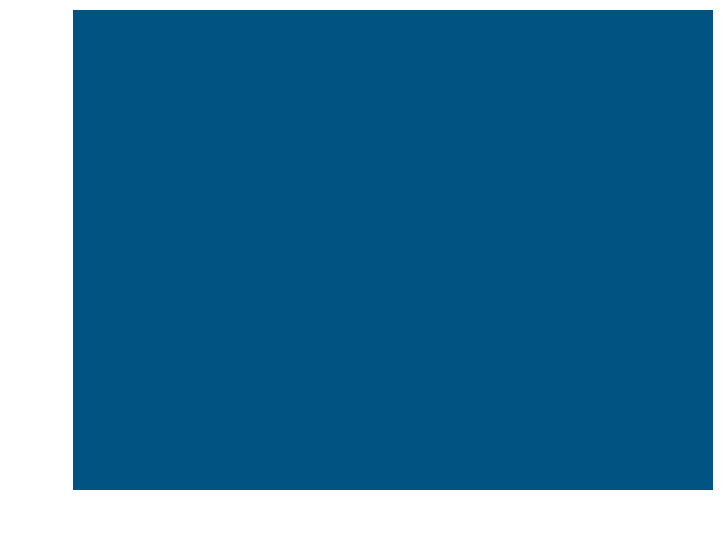

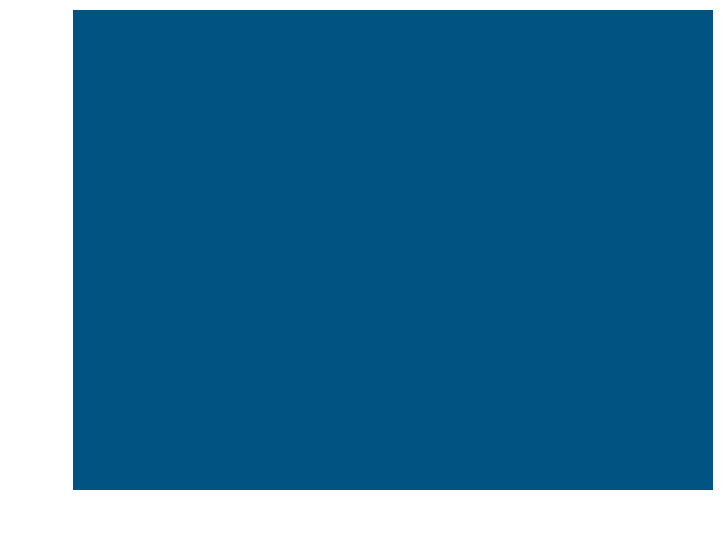

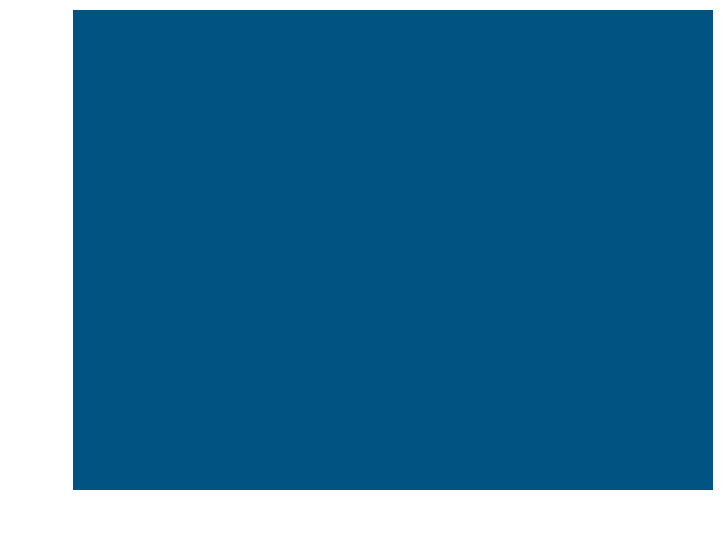

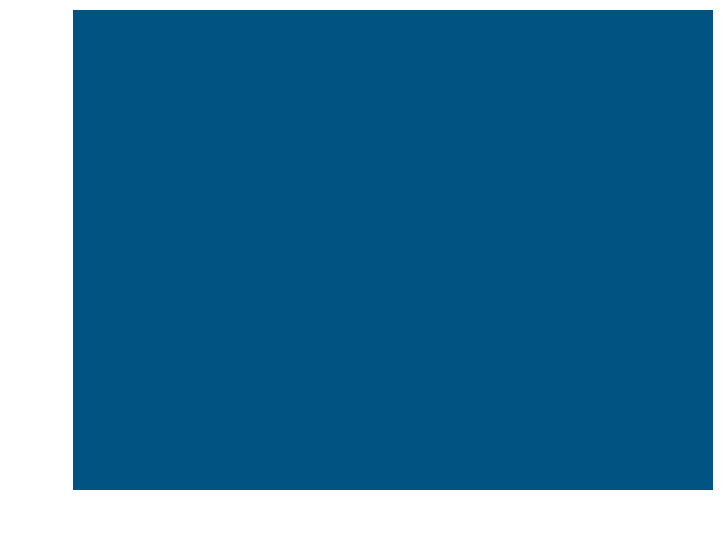

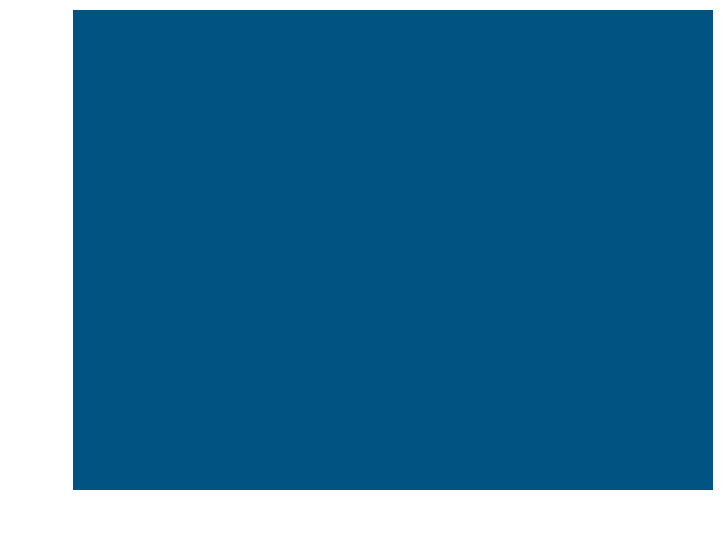

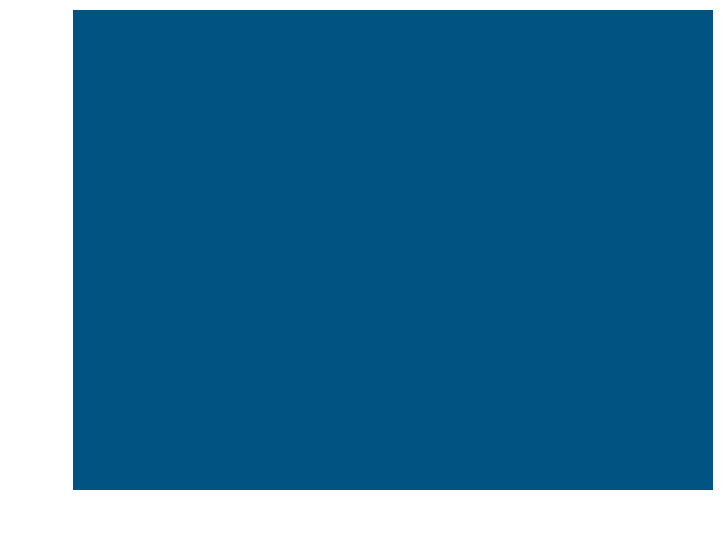

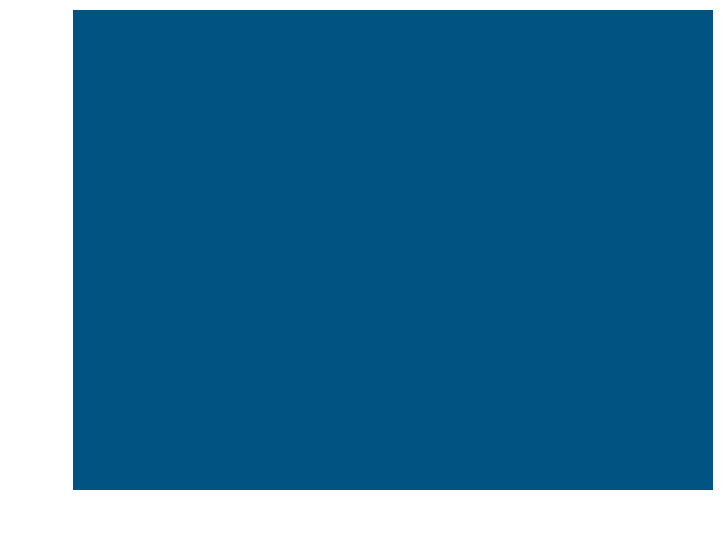

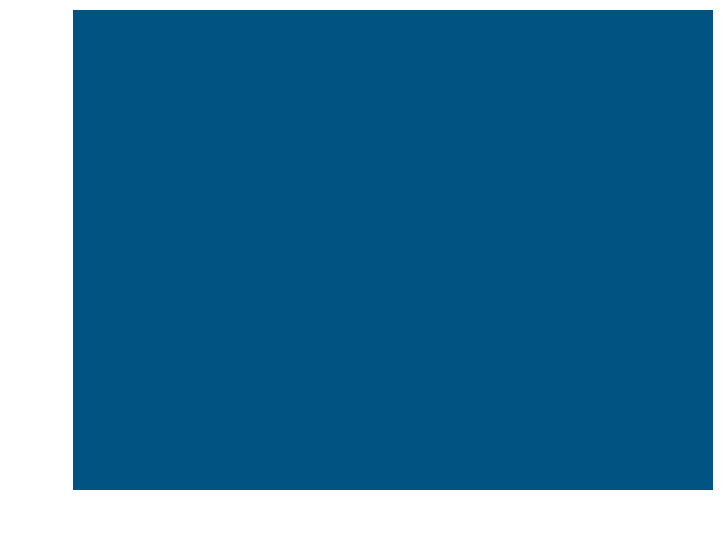

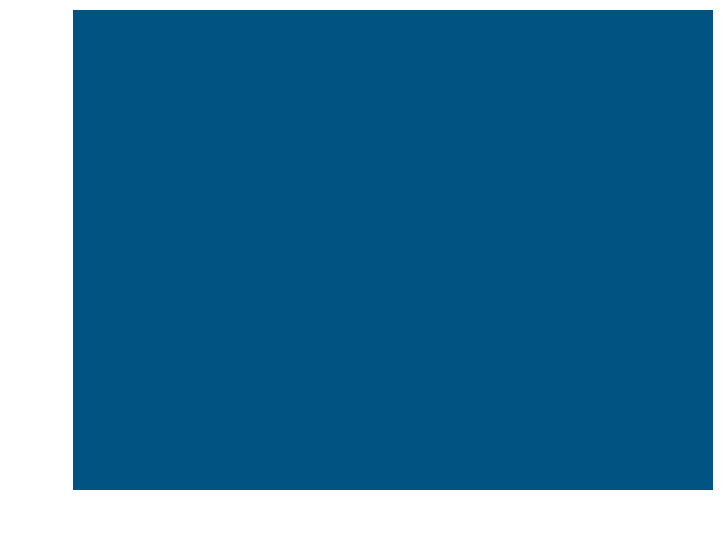

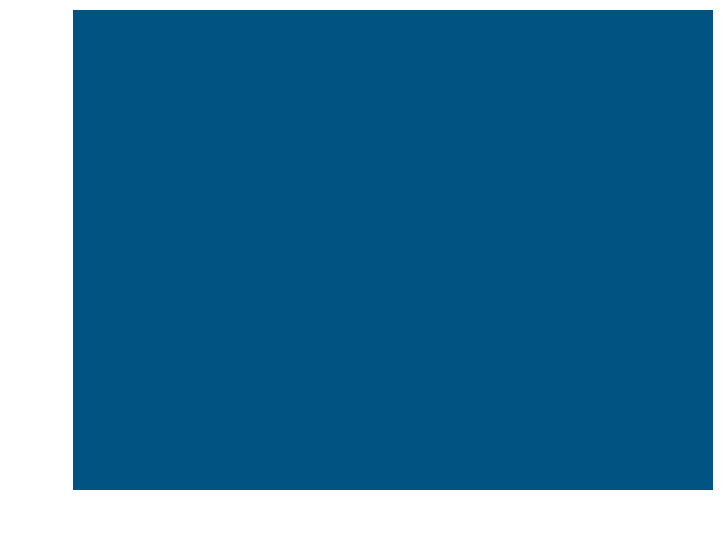

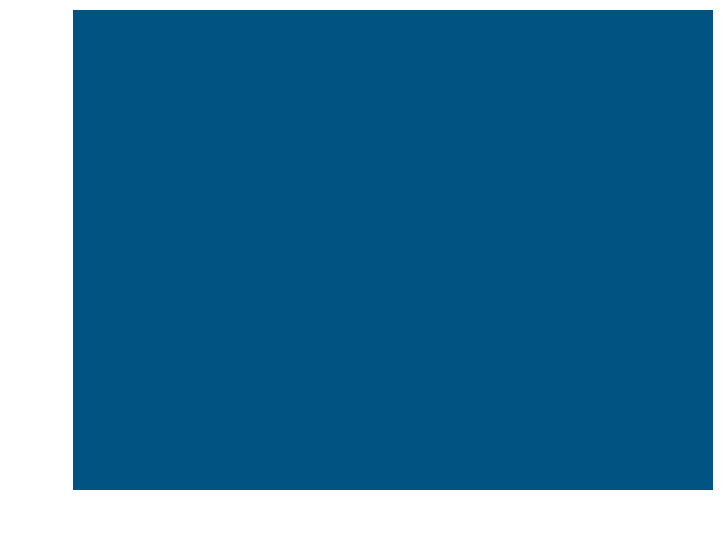

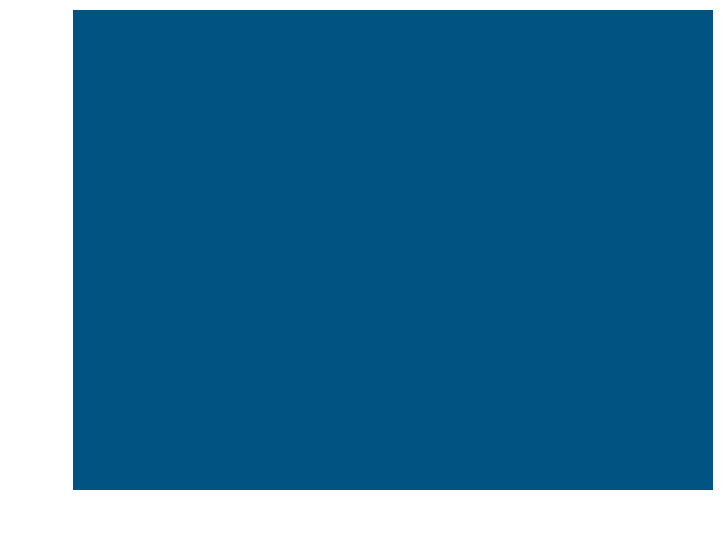

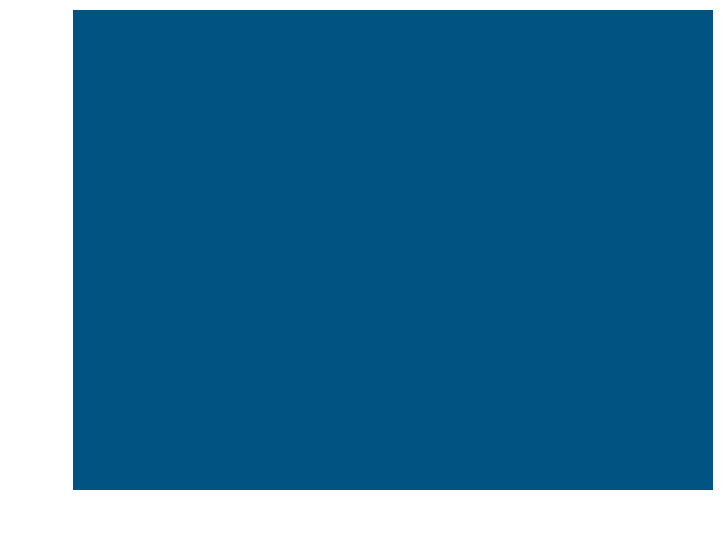

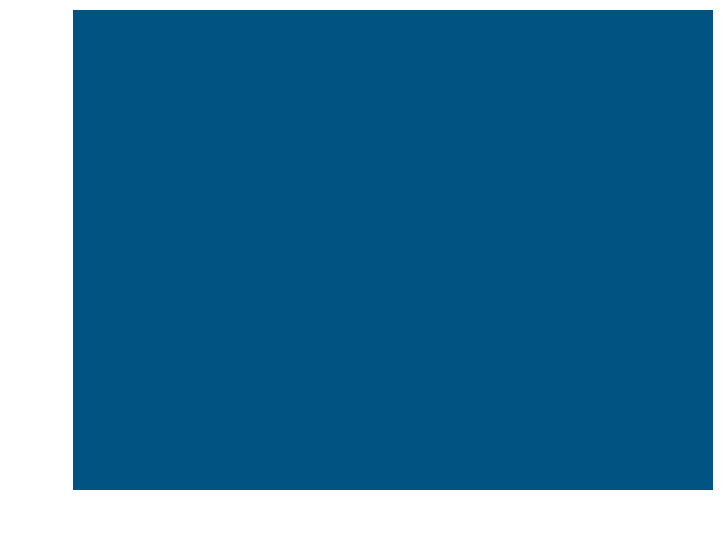

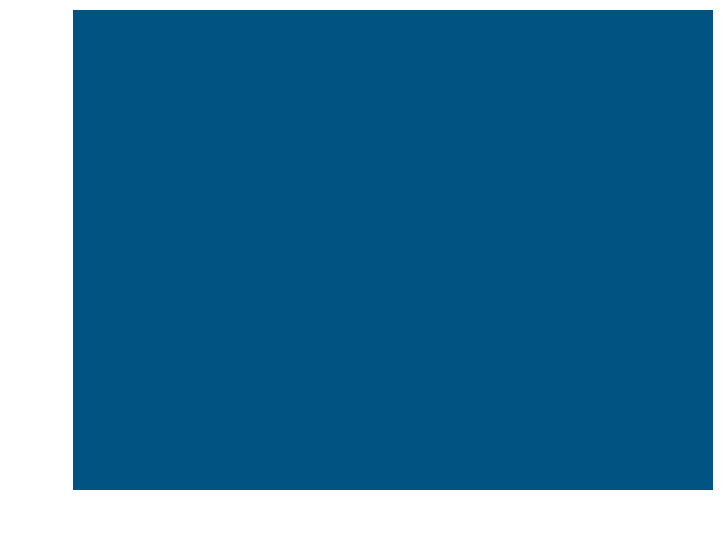

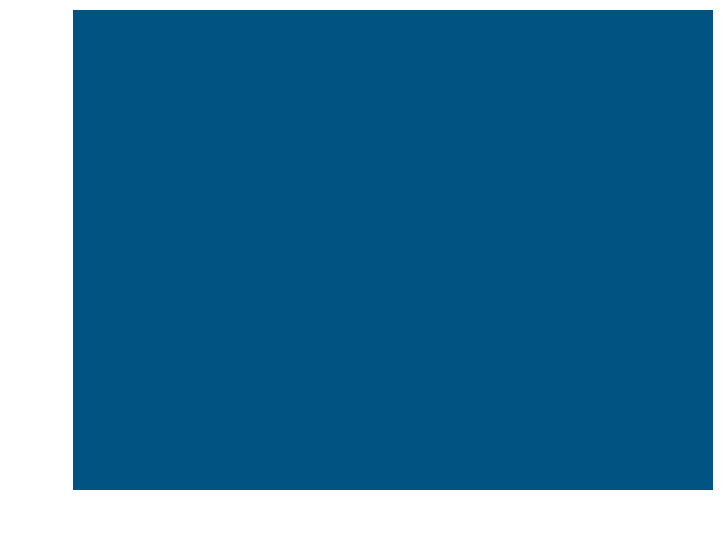

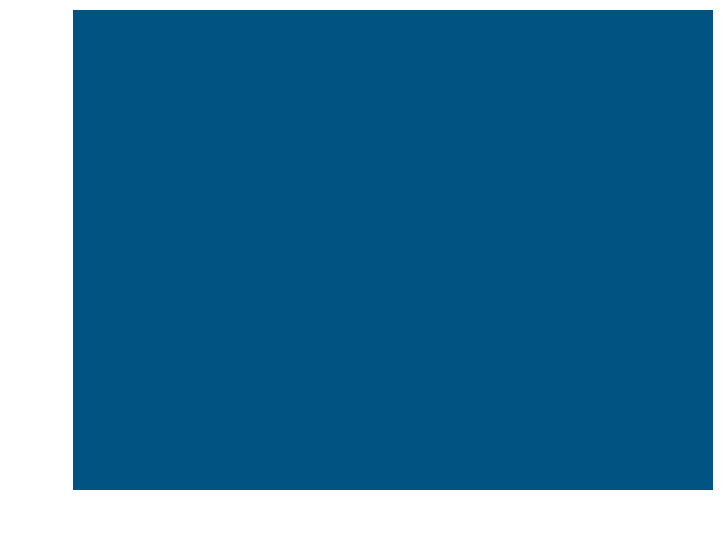

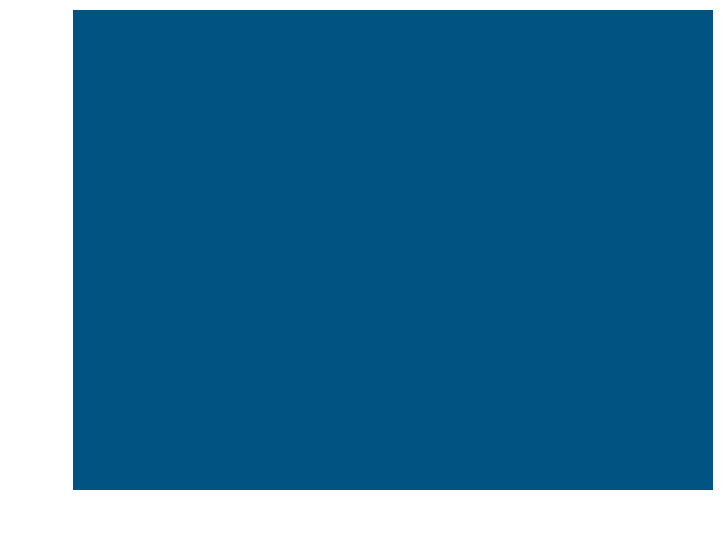

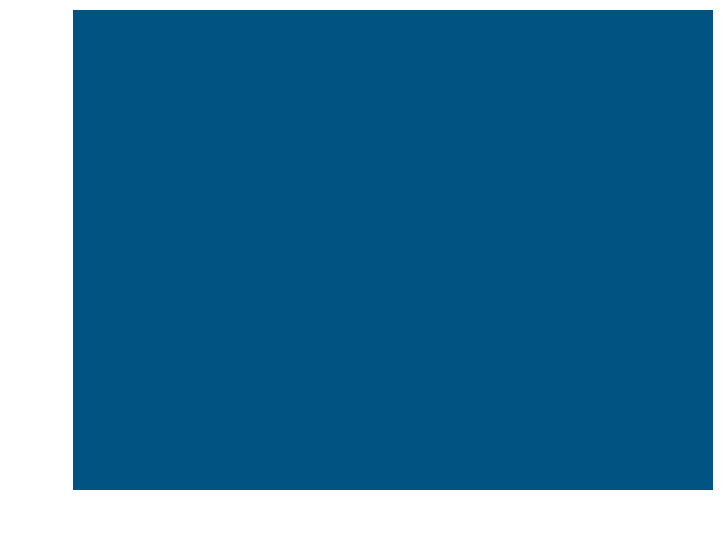

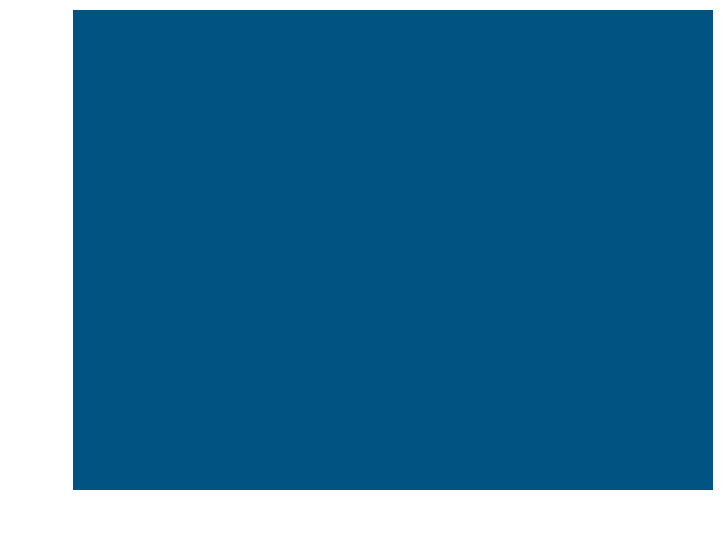

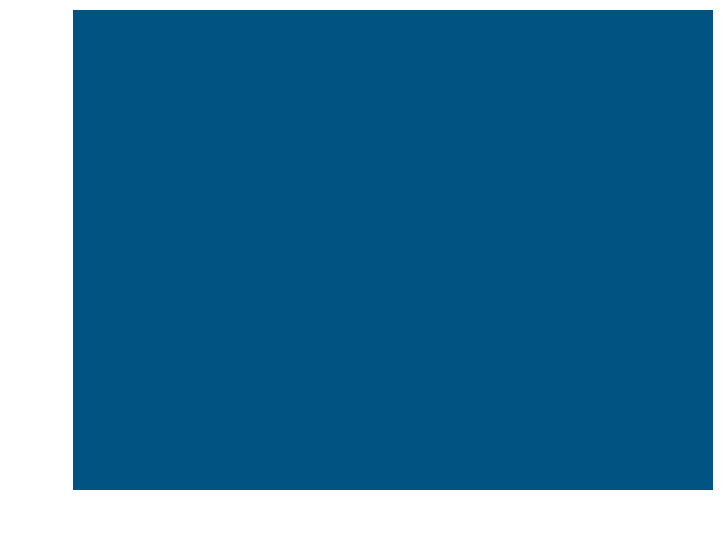

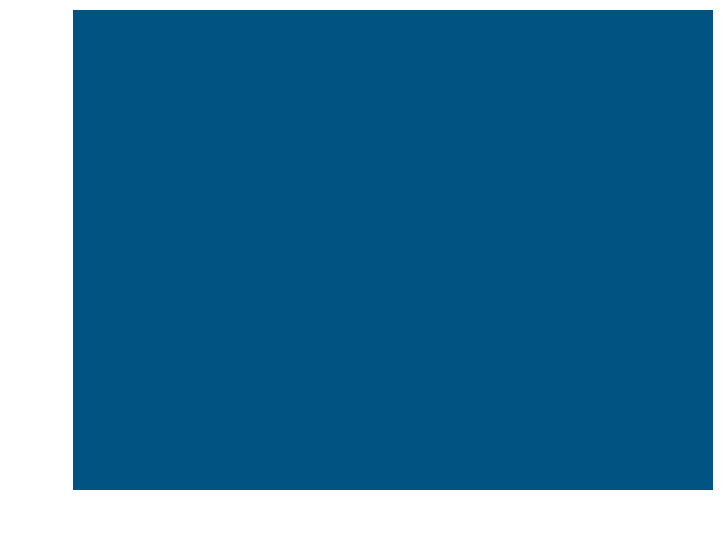

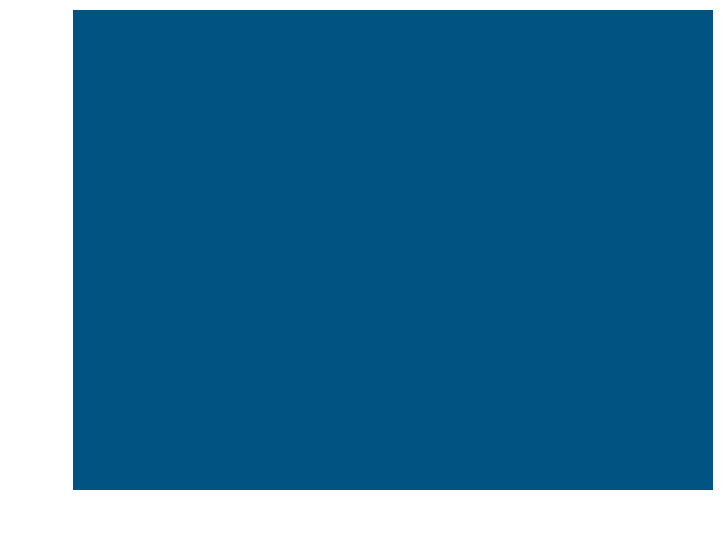

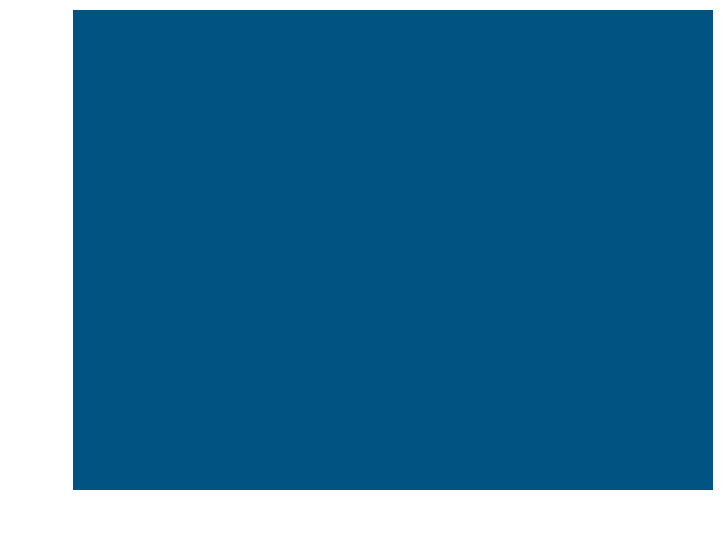

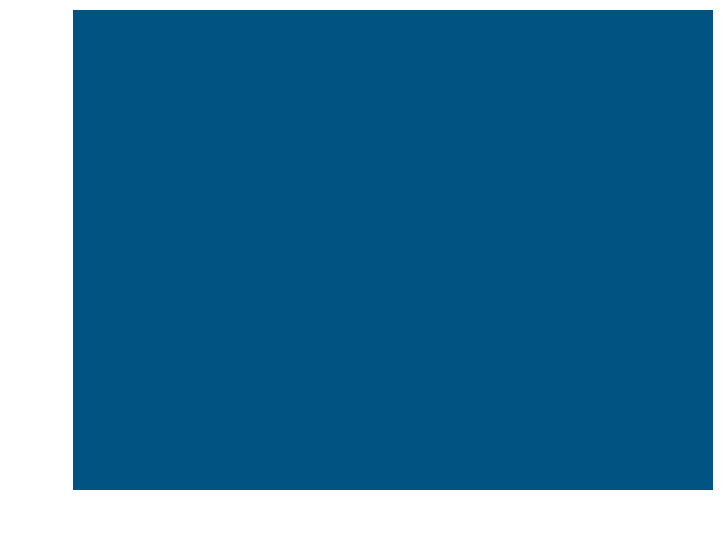

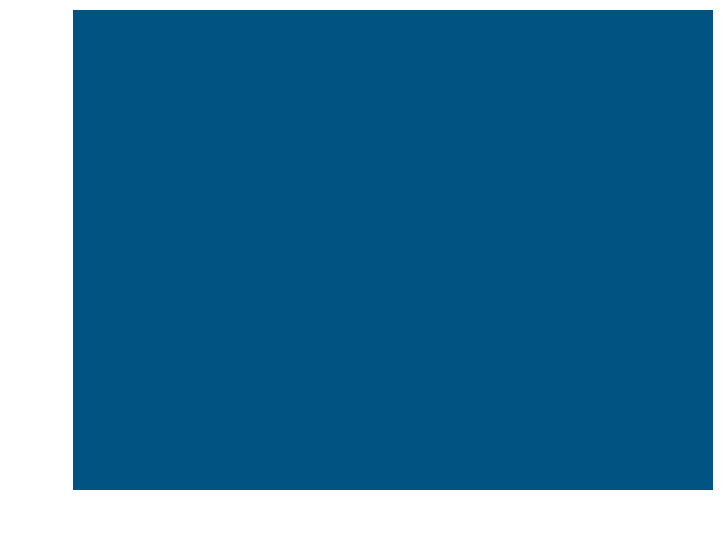

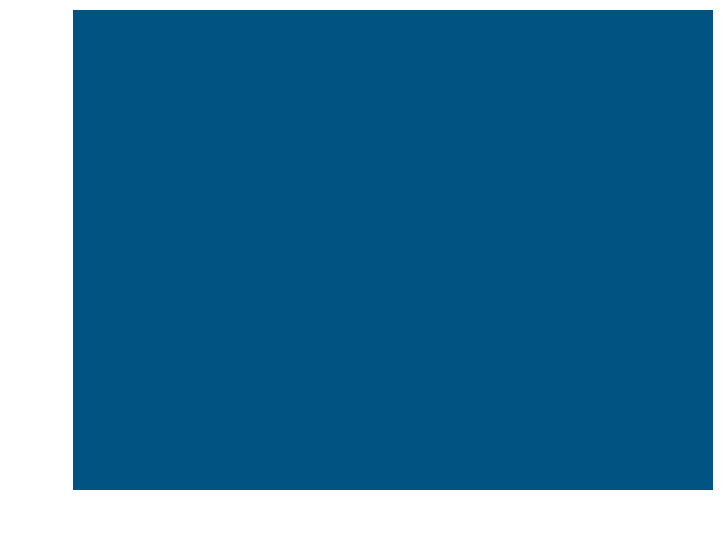

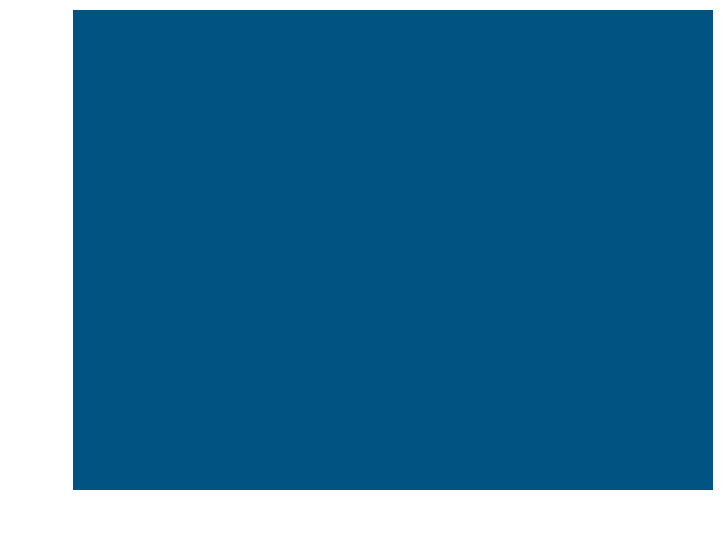

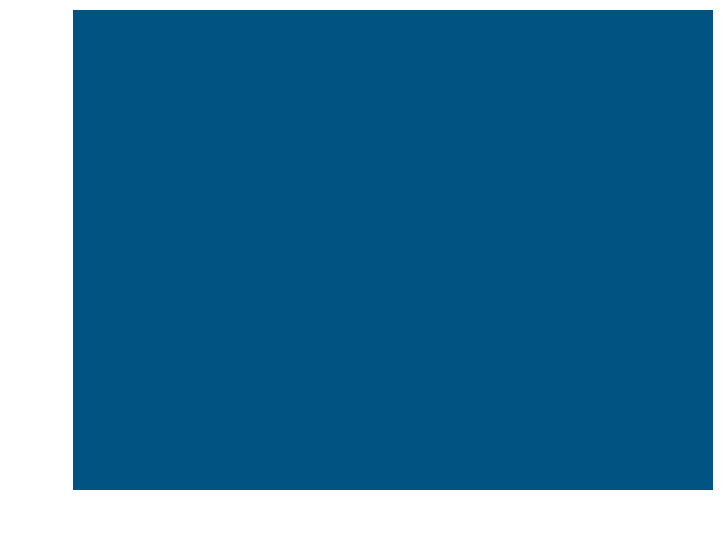

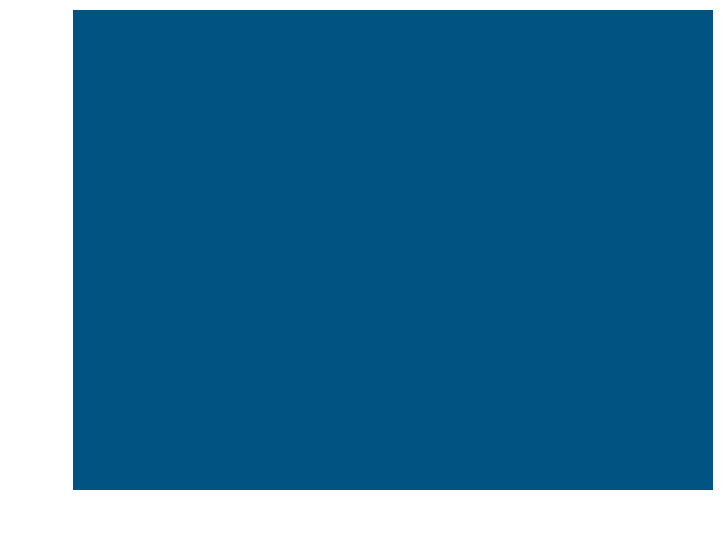

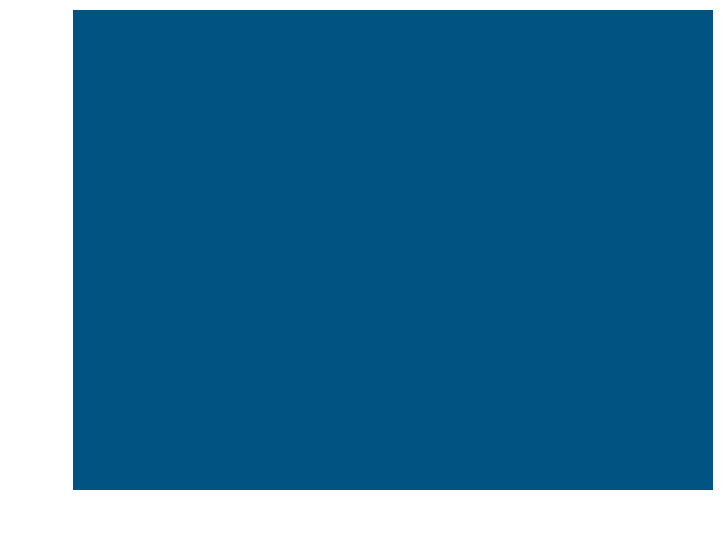

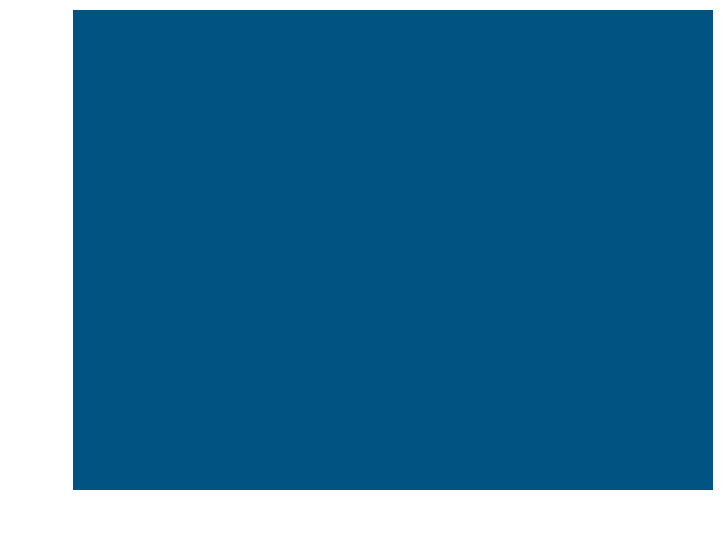

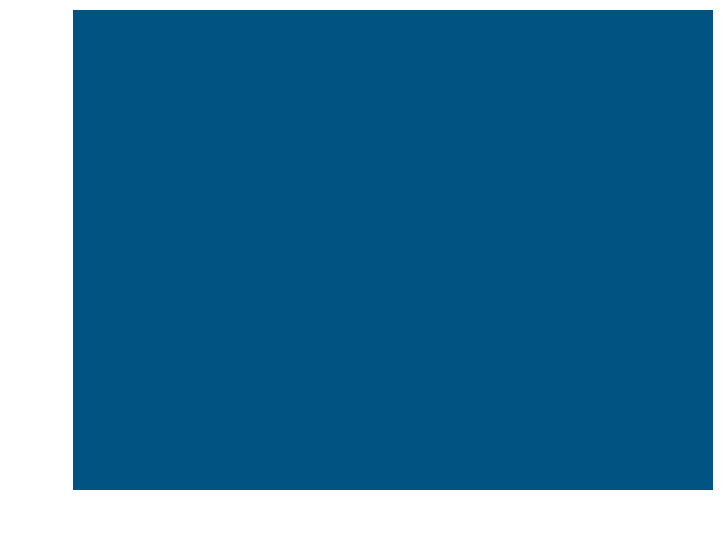

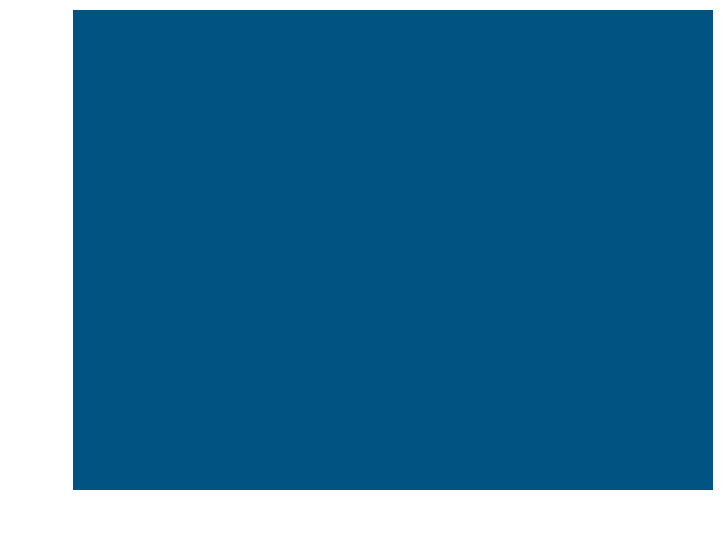

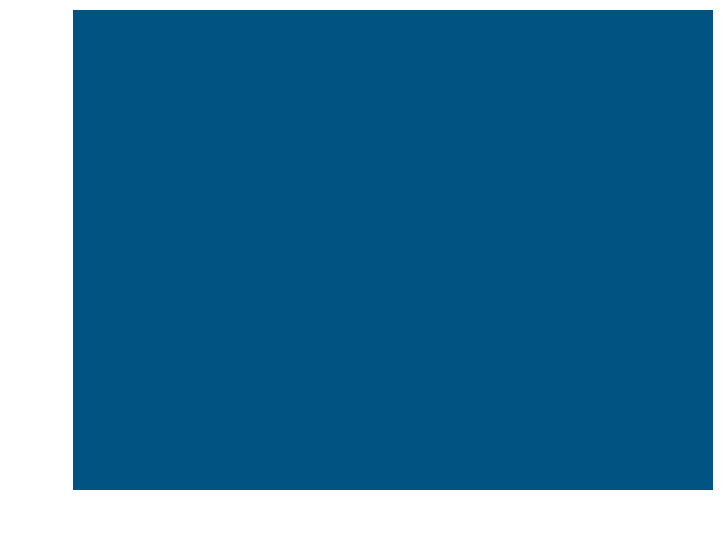

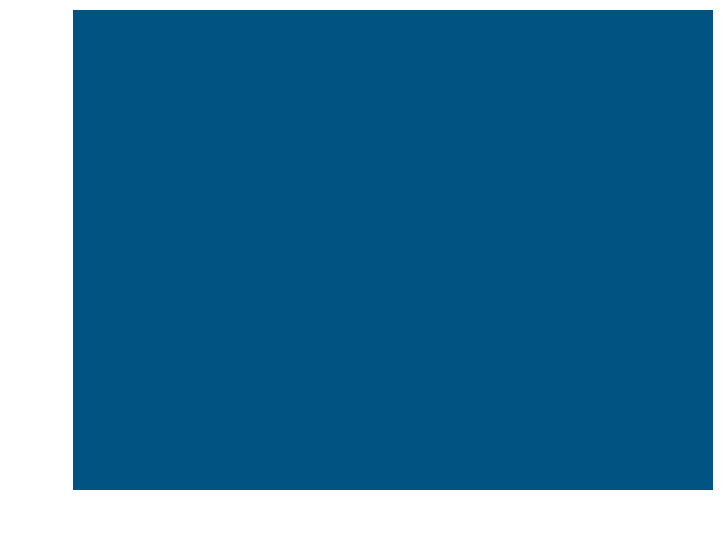

In [ ]:
%%timeit
plot_im.create_empty_frame()
plot_im.ax.pcolormesh(result, cmap=plot_im.cmap, norm=plot_im.norm)
x_grid = range(scale.output_res[0])
y_grid = range(scale.output_res[1])

In [18]:

def update():
    kinect.get_filtered_frame()
    grid.update_grid(kinect.depth)
    depth_grid_2d = grid.depth_grid[:,2].reshape((grid.output_res[1], grid.output_res[0]))

    ##not-upscaled lookup:
    index = (depth_grid_2d-scale.extent[4])/(scale.extent[5]-scale.extent[4])*(n_z_levels)#convert the z dimension to index
    index = index.round() #round to next integer
    index = index.astype('int')

    #querry the array:
    result = lith_block_reshaped[i,j,index-1] #slice the data array with the indexes

    plot_im.create_empty_frame()
    plot_im.ax.pcolormesh(result, cmap=plot_im.cmap, norm=plot_im.norm)
    x_grid = range(scale.output_res[0])
    y_grid = range(scale.output_res[1])
    elevation =grid.depth_grid.reshape((scale.output_res[1], scale.output_res[0], 3))[:, :, 2]
    plot_im.add_contours(geo_module.main_contours, [x_grid, y_grid, elevation])
    plot_im.add_contours(geo_module.sub_contours, [x_grid, y_grid, elevation])
    plot_im.save(outfile='./temp/current_frame.png')
    projector.show()


In [21]:
%%timeit
update()

1.22 s ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
while True:
    update()

KeyboardInterrupt: 

In [150]:
elevation.shape

(184, 244)

In [ ]:


    def render_geo_map(self, block, fault_blocks, outfile=None):
        """

        Args:
            block:
            fault_blocks:
            outfile:

        Returns:

        """
        if outfile is None:
            outfile = os.path.join(self.work_directory, "current_frame.png")

        self.geol_map.render_frame(block)

        elevation = self.kinect_grid.depth_grid.reshape((self.kinect_grid.scale.output_res[1],
                                                         self.kinect_grid.scale.output_res[0], 3))[:, :, 2]
        # This line is for GemPy 1.2: fault_data = sol.fault_blocks.reshape((scalgeol_map.outfilee.output_res[1],
        # scale.output_res[0]))

        if self.plot_faults is True:
            for fault in fault_blocks:
                fault = fault.reshape((self.kinect_grid.scale.output_res[1], self.kinect_grid.scale.output_res[0]))
                self.geol_map.add_contours(self.fault_line, [self.x_grid, self.y_grid, fault])
        if self.plot_topography is True:
            self.geol_map.add_contours(self.main_contours, [self.x_grid, self.y_grid, elevation])
            self.geol_map.add_contours(self.sub_contours, [self.x_grid, self.y_grid, elevation])

        self.geol_map.save(outfile=outfile)        

(102, 286)

4.27

785

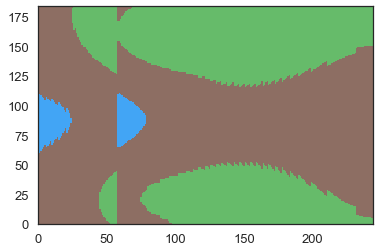

In [136]:
import matplotlib.pyplot as plt

plt.pcolormesh(result, cmap=gp.plotting.colors.cmap, norm=gp.plotting.colors.norm )
plt.show()

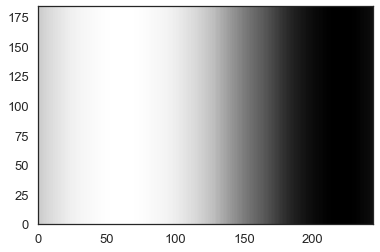

In [117]:
plt.pcolormesh(depth_grid_2d )
plt.show()

In [ ]:
#from gempy loop:
                lith, fault = self.module.compute_model(depth)
                self.module.render_geo_map(lith, fault, outfile=self.path)